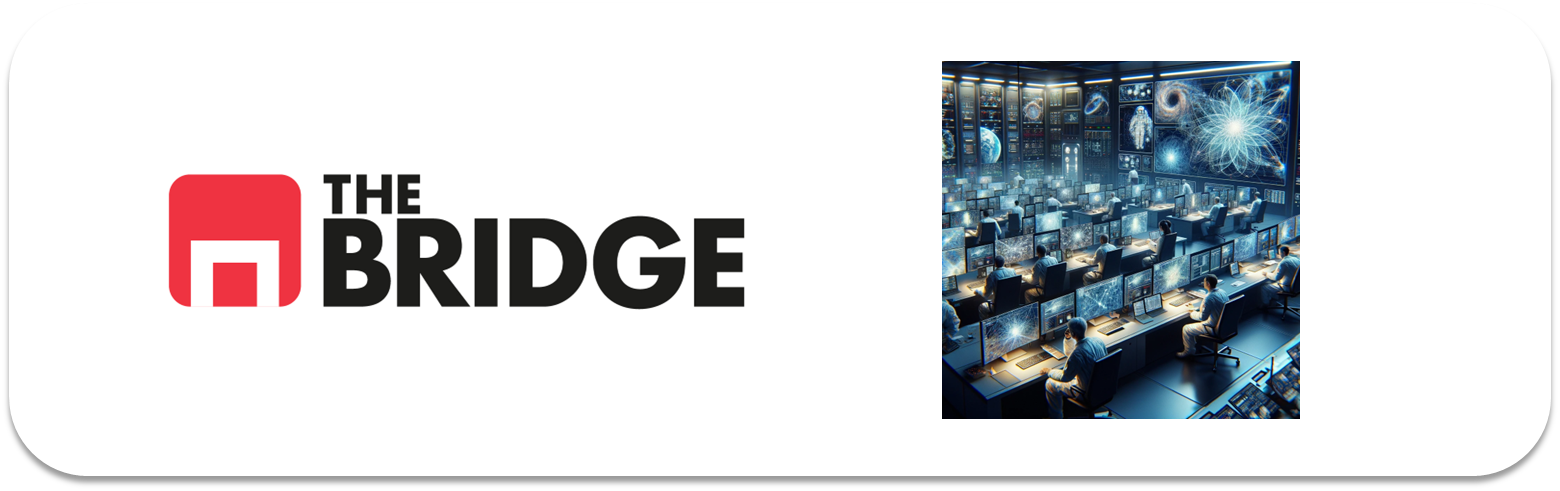

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [55]:
import bootcampviztools as bt
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import warnings
import cv2
from PIL import Image

# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

from skimage.io import imread

In [2]:
def plot_animals(animals, labels=[], names=["cat", "dog"], n_cols=5):
    n_rows = ((len(animals) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for index, animal in enumerate(animals):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(animal)
        plt.axis("off")
        
        if len(labels) > 0:
            plt.title(names[int(labels[index])])  # Convertir labels[index] a entero
    
    plt.tight_layout()
    plt.show()

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [3]:
def read_data(directorios, reshape_dim=(32, 32)):
    X = []
    y = []
    
    directorios = directorios if isinstance(directorios, list) else [directorios]
    
    for directorio in directorios:
        clase = os.path.basename(directorio)  # Obtenemos la clase ('github_train_0', 'github_train_1', etc.)
        for file in os.listdir(directorio):
            if file.endswith('.jpg'):
                filepath = os.path.join(directorio, file)
                image = imread(filepath)
                image = cv2.resize(image, reshape_dim)
                X.append(image)
                if 'cat' in file:
                    y.append("cat")
                elif 'dog' in file:
                    y.append("dog")
                else:
                    raise ValueError(f"Archivo {file} no contiene 'cat' o 'dog' en su nombre.")
    
    return np.array(X), np.array(y)

In [4]:
PATH_DATA = "./data/"
directorios = [f"{PATH_DATA}github_train_{i}" for i in range(4)] 
X_train, y_train = read_data(directorios)

In [5]:
print(np.unique(y_train))

['cat' 'dog']


In [6]:
dir_train = ['./data/github_train_0', './data/github_train_1', './data/github_train_2', './data/github_train_3']
dir_test = './data/github_test'

In [7]:
X_train, y_train = read_data(dir_train)
X_test, y_test = read_data([dir_test])

In [8]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [9]:
X_train.shape
# Entiendo que ese 3 es porque es el color, con los canales RGB

(4000, 32, 32, 3)

In [10]:
#target = y

In [11]:
#plot_animals(X_train[:10], labels=y_train[:10], names=["cat", "dog"])
# solo sale 1 gato, sin label y con error :(

In [12]:
#bt.pinta_distribucion_categoricas(X_train, [target], True, True)
# Tb me da error :(

In [13]:
pd.Series(y_train).value_counts(True)
# vaya, ha costado pero tengo mis bichos equilibrados...

cat    0.5
dog    0.5
Name: proportion, dtype: float64

In [14]:
X_train = X_train / 255
X_test = X_test / 255

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(filters=8, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(rate=0.25))

In [19]:
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2))) 
model.add(Dropout(0.25))

In [20]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5920 - loss: 0.7224 - val_accuracy: 0.0000e+00 - val_loss: 1.0192
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6271 - loss: 0.6637 - val_accuracy: 0.0000e+00 - val_loss: 0.8741
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6441 - loss: 0.6353 - val_accuracy: 0.5437 - val_loss: 0.6954
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6613 - loss: 0.6248 - val_accuracy: 0.1612 - val_loss: 0.9375
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6778 - loss: 0.6045 - val_accuracy: 0.3400 - val_loss: 0.8069
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6795 - loss: 0.5910 - val_accuracy: 0.6675 - val_loss: 0.6405
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6741 - loss: 0.5949 - val_accuracy: 0.4325 - val_loss: 0.7631
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7051 - loss: 0.5704 - val_accu

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 794,072 (3.03 MB)

 Trainable params: 264,690 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 529,382 (2.02 MB)

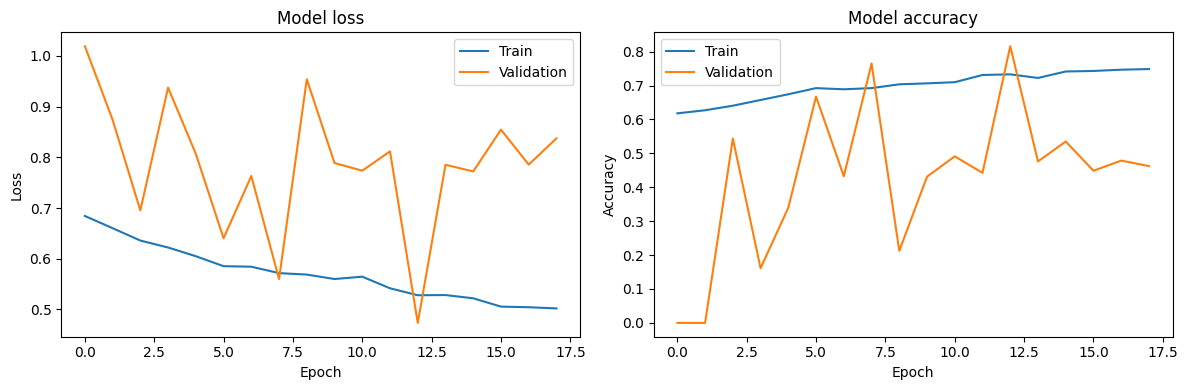

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [25]:
X_train.size

12288000

In [26]:
optimizer = Adam(learning_rate =0.001, beta_1=0.9, beta_2=0.999) 

In [27]:
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,690 (1.01 MB)

 Trainable params: 264,690 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
batch_size = 128
epochs = 100
validation_split = 0.2

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=[early_stopping])
# Vale, la accuracy ahora pasó de 0.4 a 0.6, sigue siendo muy mala

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9734 - loss: 0.0648 - val_accuracy: 0.6438 - val_loss: 1.3745
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9819 - loss: 0.0560 - val_accuracy: 0.5925 - val_loss: 1.6112
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9705 - loss: 0.0807 - val_accuracy: 0.5888 - val_loss: 1.6184
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9755 - loss: 0.0692 - val_accuracy: 0.6712 - val_loss: 1.2346
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9755 - loss: 0.0679 - val_accuracy: 0.6137 - val_loss: 1.4346
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9780 - loss: 0.0669 - val_accuracy: 0.5713 - val_loss: 1.6169
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9777 - loss: 0.0632 - val_accuracy: 0.5962 - val_loss: 1.4870
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9765 - loss: 0.0635 - val_accuracy: 0.

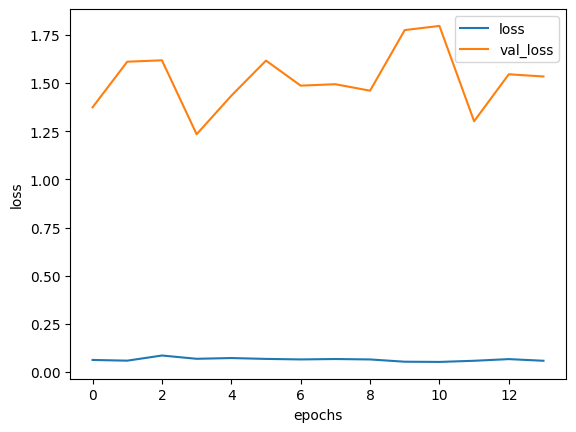

In [36]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

In [37]:
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.975312,0.063040,0.64375,1.374499
1,0.979062,0.059303,0.59250,1.611183
2,0.967500,0.086049,0.58875,1.618355
3,0.975000,0.069027,0.67125,1.234558
4,0.974688,0.072898,0.61375,1.434565
5,0.975937,0.068422,0.57125,1.616942
6,0.977188,0.065734,0.59625,1.486977
7,0.975000,0.067826,0.61500,1.494364
8,0.975000,0.065626,0.61250,1.460653
9,0.981562,0.053858,0.55375,1.775408


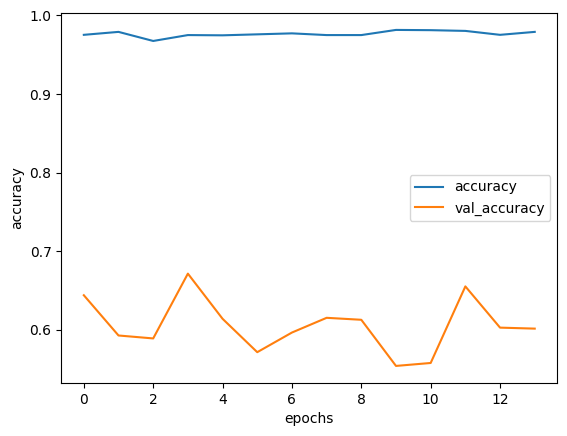

In [38]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

In [40]:
model.evaluate(X_test,y_test_encoded)
# Ah, pero ahora la accuracy contra test es +0.72? Mejor aqui que con train...

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7196 - loss: 0.8633


[0.9998147487640381, 0.6980000138282776]

In [41]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [43]:
print(classification_report(y_test_encoded,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       500
           1       0.71      0.67      0.69       500

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



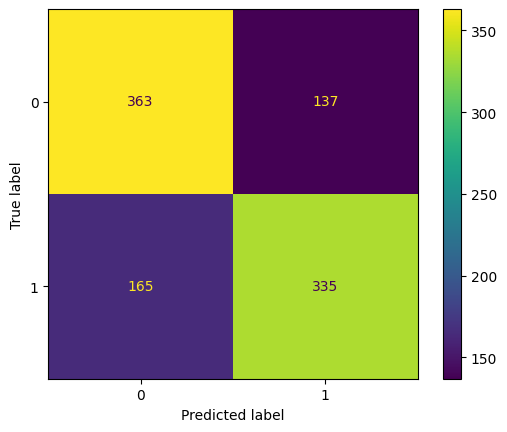

In [45]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred)
# Si 1 es perro, parecería que no los detecta y casi todos los toma por gatos

In [46]:
y_train_decoded = le.inverse_transform(y_train_encoded)
y_test_decoded = le.inverse_transform(y_test_encoded)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total de imágenes mal clasificadas: 302
Número de imágenes seleccionadas: 30


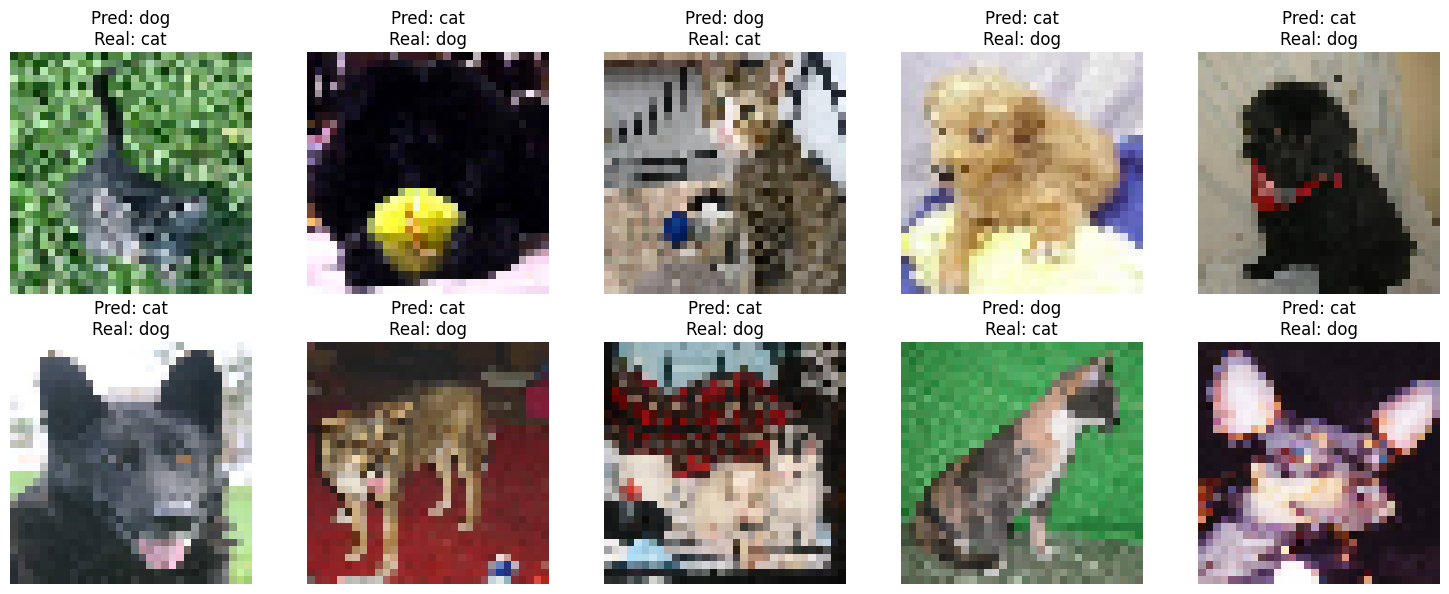

In [48]:
# Chat GPT sugiere que resuelva la última parte así:

# Predecir las probabilidades de las clases para las imágenes de prueba
y_pred_prob = model.predict(X_test)

# Obtener las clases predichas y sus probabilidades máximas
y_pred = np.argmax(y_pred_prob, axis=1)
max_prob = np.max(y_pred_prob, axis=1)

# Identificar las imágenes mal clasificadas
misclassified_indices = np.where(y_pred != y_test_encoded)[0]

# Ordenar las imágenes mal clasificadas por probabilidad de la clase predicha incorrecta (más alta primero)
misclassified_sorted = sorted(misclassified_indices, key=lambda i: max_prob[i], reverse=True)

# Calcular cuántas imágenes conforman el 10% de las mal clasificadas
num_images_to_select = int(len(misclassified_sorted) * 0.1)

# Seleccionar las primeras num_images_to_select imágenes con la mayor confianza en la clasificación incorrecta
selected_indices = misclassified_sorted[:num_images_to_select]

# Mostrar algunas estadísticas
print(f"Total de imágenes mal clasificadas: {len(misclassified_indices)}")
print(f"Número de imágenes seleccionadas: {len(selected_indices)}")

# Visualizar algunas de las imágenes seleccionadas
plt.figure(figsize=(15, 6))
for i, idx in enumerate(selected_indices[:10]):  # Mostrar solo las primeras 10 imágenes seleccionadas
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Pred: {le.classes_[y_pred[idx]]}\nReal: {le.classes_[y_test_encoded[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Pero a ver si consigo algo mejor que ese 0.7, también siguiendo lo que me indica chatgpt

In [56]:
def build_model(filters, kernel_size, dense_units, dropout_rate):
    model = Sequential()
    
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='Same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(rate=dropout_rate))
    
    model.add(Conv2D(filters=filters*2, kernel_size=kernel_size, padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(rate=dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=2, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [57]:
filters_values = [8, 16]
kernel_size_values = [(3, 3), (5, 5)]
dense_units_values = [128, 256]
dropout_rate_values = [0.25, 0.5]

best_accuracy = 0.0
best_params = {}

In [58]:
for filters in filters_values:
    for kernel_size in kernel_size_values:
        for dense_units in dense_units_values:
            for dropout_rate in dropout_rate_values:
                print(f"Entrenando modelo con filters={filters}, kernel_size={kernel_size}, dense_units={dense_units}, dropout_rate={dropout_rate}")
                
                # Construir el modelo
                model = build_model(filters=filters, kernel_size=kernel_size, dense_units=dense_units, dropout_rate=dropout_rate)
                
                # Entrenar el modelo
                history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                
                # Evaluar el modelo
                _, accuracy = model.evaluate(X_test, y_test_encoded)
                
                print(f"Accuracy: {accuracy}")
                
                # Guardar los mejores parámetros
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'filters': filters,
                        'kernel_size': kernel_size,
                        'dense_units': dense_units,
                        'dropout_rate': dropout_rate
                    }

print("Mejores parámetros encontrados:")
print(best_params)
print("Mejor precisión encontrada:")
print(best_accuracy)

Entrenando modelo con filters=8, kernel_size=(3, 3), dense_units=128, dropout_rate=0.25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7846 - loss: 0.5520
Accuracy: 0.7200000286102295
Entrenando modelo con filters=8, kernel_size=(3, 3), dense_units=128, dropout_rate=0.5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.4350
Accuracy: 0.6899999976158142
Entrenando modelo con filters=8, kernel_size=(3, 3), dense_units=256, dropout_rate=0.25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7674 - loss: 0.6265
Accuracy: 0.7139999866485596
Entrenando modelo con filters=8, kernel_size=(3, 3), dense_units=256, dropout_rate=0.5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.4418
Accuracy: 0.7110000252723694
Entrenando modelo con filters=8, kernel_size=(5, 5), dense_units=128, dropout_rate=0.25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7570 - loss: 0.5472
Accuracy: 0.6919999718666077
Entrenando modelo con filters=8, kernel_size=(5, 5),

In [59]:
# Con todo esto ha conseguido subir 3 décimas, de 0.72 a 0.75
#Mejores parámetros encontrados:
#{'filters': 16, 'kernel_size': (3, 3), 'dense_units': 256, 'dropout_rate': 0.25}
#Mejor precisión encontrada:
#0.7519999742507935

In [61]:
best_filters = 16
best_kernel_size = (3, 3)
best_dense_units = 256
best_dropout_rate = 0.25

In [62]:
model = Sequential()
model.add(Conv2D(filters=best_filters, kernel_size=best_kernel_size, padding='Same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=best_dropout_rate))

model.add(Flatten())
model.add(Dense(best_dense_units, activation='relu'))
model.add(Dropout(best_dropout_rate))
model.add(Dense(2, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los datos de entrenamiento
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5614 - loss: 0.9010 - val_accuracy: 0.0000e+00 - val_loss: 0.9425
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6304 - loss: 0.6505 - val_accuracy: 0.6712 - val_loss: 0.6442
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6794 - loss: 0.6070 - val_accuracy: 0.2150 - val_loss: 1.0262
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7042 - loss: 0.5649 - val_accuracy: 0.4425 - val_loss: 0.8381
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7328 - loss: 0.5423 - val_accuracy: 0.6300 - val_loss: 0.6413
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7519 - loss: 0.5028 - val_accuracy: 0.3487 - val_loss: 0.9461
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7716 - loss: 0.4905 - val_accuracy: 0.1637 - val_loss: 1.4082
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7732 - loss: 0.4685 - val_

In [63]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Accuracy: {accuracy:.4f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7124 - loss: 0.5592
Accuracy: 0.6830


In [65]:
model.evaluate(X_test,y_test_encoded)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7124 - loss: 0.5592


[0.5958526730537415, 0.6830000281333923]

In [66]:
y_pred_prob = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [67]:
y_pred = np.argmax(y_pred_prob, axis=1)

In [68]:
print(classification_report(y_test_encoded,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       500
           1       0.70      0.63      0.67       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000



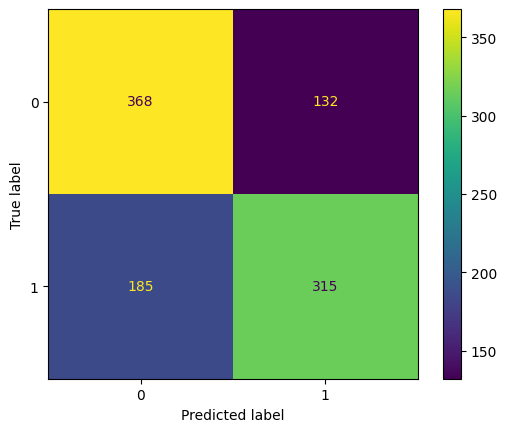

In [69]:
ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred)

In [70]:
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))
# Bastante poco fiable, en general...Cantidad de perros que toma por gatos, sobre todo (185)

              precision    recall  f1-score   support

         cat       0.67      0.74      0.70       500
         dog       0.70      0.63      0.67       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000

